In [3]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
 
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
 
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
# Define labels for the target variable
LABELS = ["Show", "No Show"]
 

In [4]:
import psutil
print(psutil.__version__)

6.0.0


In [5]:
# Load datasets
data = pd.read_csv('data/no_show.csv')


In [6]:
data.head(2)

,Gender,Age,Alcohol_Consumption,Hypertension,Diabetes,Appointment_Date,Schedule_Date,Clinic_Location,Specialty,Neighborhood,clinic,lat,long,neighborho,target_no_show
0,F,43,5/week,False,False,2021-01-14 10:30:00,2020-10-26,Mission Bay,Human Performance Center,Russian Hill,Mission Bay,37.764124,-122.456572,Russian Hill,False
1,F,43,5/week,False,False,2021-01-14 10:30:00,2020-10-26,Mission Bay,Human Performance Center,Russian Hill,Mission Bay,37.784882,-122.438723,Russian Hill,False


In [5]:
# Remove specified columns
data = data.drop(columns=['lat', 'long', 'neighborho', 'clinic'])

In [6]:
# Create age group categories and convert to one-hot encoding
data['age_group'] = pd.cut(data['Age'], bins=[0, 30, 40, 50, 60, 100], labels=['<30', '30-40', '40-50', '50-60', '>60'])
data = pd.get_dummies(data, columns=['age_group'], drop_first=True)
 

In [7]:
data.drop(['Age'],axis='columns',inplace=True)

In [8]:
# Map 'Alcohol Consumption' to numeric values
mapping_dict = {'0/week': 0, '1/week': 1, '5/week': 2, '10/week': 3, '> 14/week': 4}
data['Alcohol_Consumption'] = data['Alcohol_Consumption'].map(mapping_dict)

In [9]:
# Convert 'Hypertension' and 'Diabetes' to integer
data['Hypertension'] = data['Hypertension'].astype(int)
data['Diabetes'] = data['Diabetes'].astype(int)

In [10]:
# Convert 'target_no_show' to integer
data['target_no_show'] = data['target_no_show'].astype(int)

In [11]:
# Convert date columns to datetime format and extract features
data['Appointment_Date'] = pd.to_datetime(data['Appointment_Date'])
data['Schedule_Date'] = pd.to_datetime(data['Schedule_Date'])
data['appointment_day'] = data['Appointment_Date'].dt.day
data['appointment_month'] = data['Appointment_Date'].dt.month
data['appointment_year'] = data['Appointment_Date'].dt.year
data['appointment_dayofweek'] = data['Appointment_Date'].dt.dayofweek
data['schedule_day'] = data['Schedule_Date'].dt.day
data['schedule_month'] = data['Schedule_Date'].dt.month
data['schedule_year'] = data['Schedule_Date'].dt.year
data['schedule_dayofweek'] = data['Schedule_Date'].dt.dayofweek
data['days_until_appointment'] = (data['Appointment_Date'] - data['Schedule_Date']).dt.days
 
# Drop the original date columns if they are not needed anymore
data.drop(columns=['Appointment_Date', 'Schedule_Date'], inplace=True)

In [12]:
data.head(2)

,Gender,Alcohol_Consumption,Hypertension,Diabetes,Clinic_Location,Specialty,Neighborhood,target_no_show,age_group_30-40,age_group_40-50,...,age_group_>60,appointment_day,appointment_month,appointment_year,appointment_dayofweek,schedule_day,schedule_month,schedule_year,schedule_dayofweek,days_until_appointment
0,F,2,0,0,Mission Bay,Human Performance Center,Russian Hill,0,False,True,...,False,14,1,2021,3,26,10,2020,0,80
1,F,2,0,0,Mission Bay,Human Performance Center,Russian Hill,0,False,True,...,False,14,1,2021,3,26,10,2020,0,80


In [13]:
# Apply One-Hot Encoding for nominal variables
data = pd.get_dummies(data, columns=['Clinic_Location', 'Specialty', 'Neighborhood'])


In [14]:
data.head(2)

,Gender,Alcohol_Consumption,Hypertension,Diabetes,target_no_show,age_group_30-40,age_group_40-50,age_group_50-60,age_group_>60,appointment_day,...,Neighborhood_Presidio,Neighborhood_Presidio Heights,Neighborhood_Russian Hill,Neighborhood_Seacliff,Neighborhood_South of Market,Neighborhood_Treasure Island/YBI,Neighborhood_Twin Peaks,Neighborhood_Visitacion Valley,Neighborhood_West of Twin Peaks,Neighborhood_Western Addition
0,F,2,0,0,0,False,True,False,False,14,...,False,False,True,False,False,False,False,False,False,False
1,F,2,0,0,0,False,True,False,False,14,...,False,False,True,False,False,False,False,False,False,False


In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
# Apply Label Encoding for ordinal or binary variables
label_encoders = {}
for column in ['Gender']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [17]:
data.head(2)

,Gender,Alcohol_Consumption,Hypertension,Diabetes,target_no_show,age_group_30-40,age_group_40-50,age_group_50-60,age_group_>60,appointment_day,...,Neighborhood_Presidio,Neighborhood_Presidio Heights,Neighborhood_Russian Hill,Neighborhood_Seacliff,Neighborhood_South of Market,Neighborhood_Treasure Island/YBI,Neighborhood_Twin Peaks,Neighborhood_Visitacion Valley,Neighborhood_West of Twin Peaks,Neighborhood_Western Addition
0,0,2,0,0,0,False,True,False,False,14,...,False,False,True,False,False,False,False,False,False,False
1,0,2,0,0,0,False,True,False,False,14,...,False,False,True,False,False,False,False,False,False,False


In [18]:
# Check data types of all columns
print(data.dtypes)


Gender                              int64
Alcohol_Consumption                 int64
Hypertension                        int64
Diabetes                            int64
target_no_show                      int64
                                    ...  
Neighborhood_Treasure Island/YBI     bool
Neighborhood_Twin Peaks              bool
Neighborhood_Visitacion Valley       bool
Neighborhood_West of Twin Peaks      bool
Neighborhood_Western Addition        bool
Length: 331, dtype: object


In [19]:
# Create independent and Dependent Features
columns = data.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["target_no_show"]]
# Store the variable we are predicting
target = "target_no_show"
 
# Define a random state
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(132202, 330)
(132202,)


In [23]:
# Count the number of 0s and 1s in the 'target_no_show' column
value_counts = data['target_no_show'].value_counts()

# Print the counts
print(f"Number of 0s in 'target_no_show': {value_counts[0]}")
print(f"Number of 1s in 'target_no_show': {value_counts[1]}")



Number of 0s in 'target_no_show': 126852
Number of 1s in 'target_no_show': 5350


In [20]:
# Remove rows with any missing values
data = data.dropna()
 

In [21]:
# Check if there are still any missing values
data.isnull().values.any()

np.False_

/var/folders/0z/lpdq6xc50fb_51rn5s1nddzh0000gn/T/ipykernel_8792/2461647304.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd. value_counts(data[ 'target_no_show'], sort = True)


Text(0, 0.5, 'Frequency')

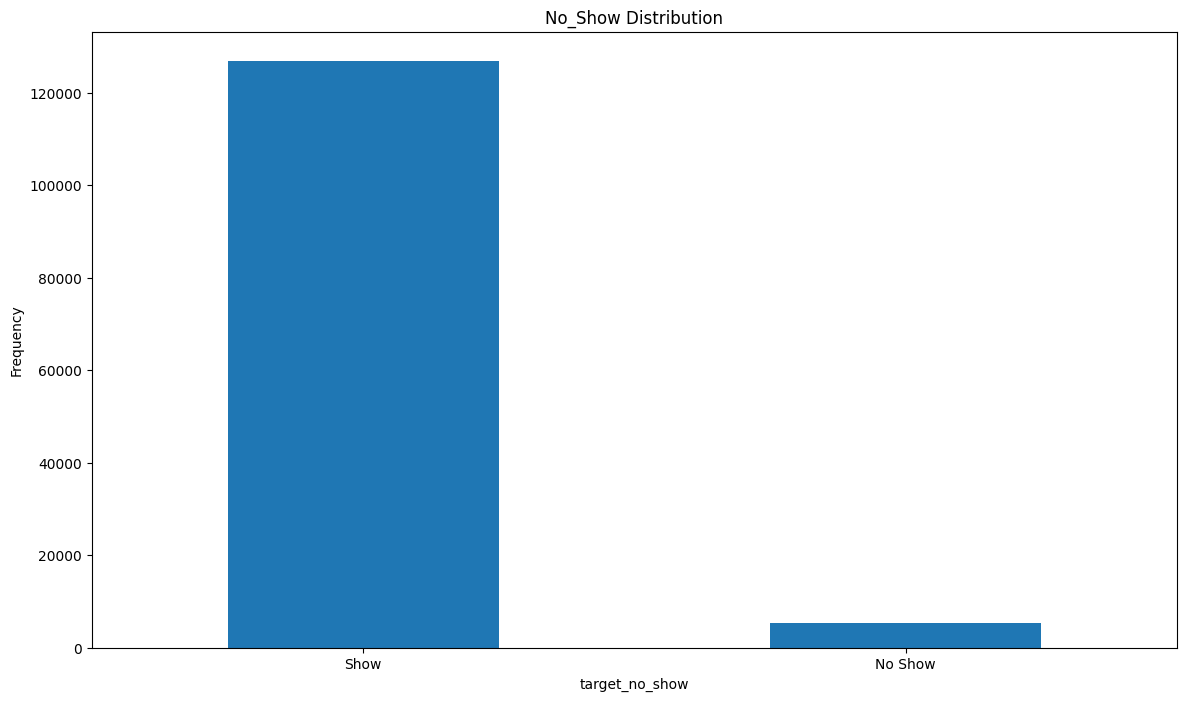

In [24]:
count_classes = pd. value_counts(data[ 'target_no_show'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt. title("No_Show Distribution")
plt. xticks(range(2), LABELS)
plt. xlabel("target_no_show")
plt. ylabel ("Frequency")

In [25]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, Y)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Initialize Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(y_test, y_pred):
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Print the results
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Return the results in a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix
    }





# Evaluate the model
evaluate_model(y_test, y_pred)


Accuracy: 0.99
Precision: 1.00
Recall: 0.98
F1 Score: 0.99
Confusion Matrix:
[[37895    27]
 [  663 37527]]


{'accuracy': 0.9909344124448182,
 'precision': np.float64(0.9992810353091548),
 'recall': np.float64(0.9826394344069128),
 'f1': np.float64(0.9908903675538656),
 'confusion_matrix': array([[37895,    27],
        [  663, 37527]])}

In [26]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of shows and no-shows after SMOTE
counter = Counter(y_res)
print(f"Number of shows (0): {counter[0]}")
print(f"Number of no-shows (1): {counter[1]}")

# Optionally, you can use value_counts() as well
print(y_res.value_counts())


Number of shows (0): 126852
Number of no-shows (1): 126852
target_no_show
0    126852
1    126852
Name: count, dtype: int64


/var/folders/0z/lpdq6xc50fb_51rn5s1nddzh0000gn/T/ipykernel_8792/2258187121.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_res, palette='viridis')


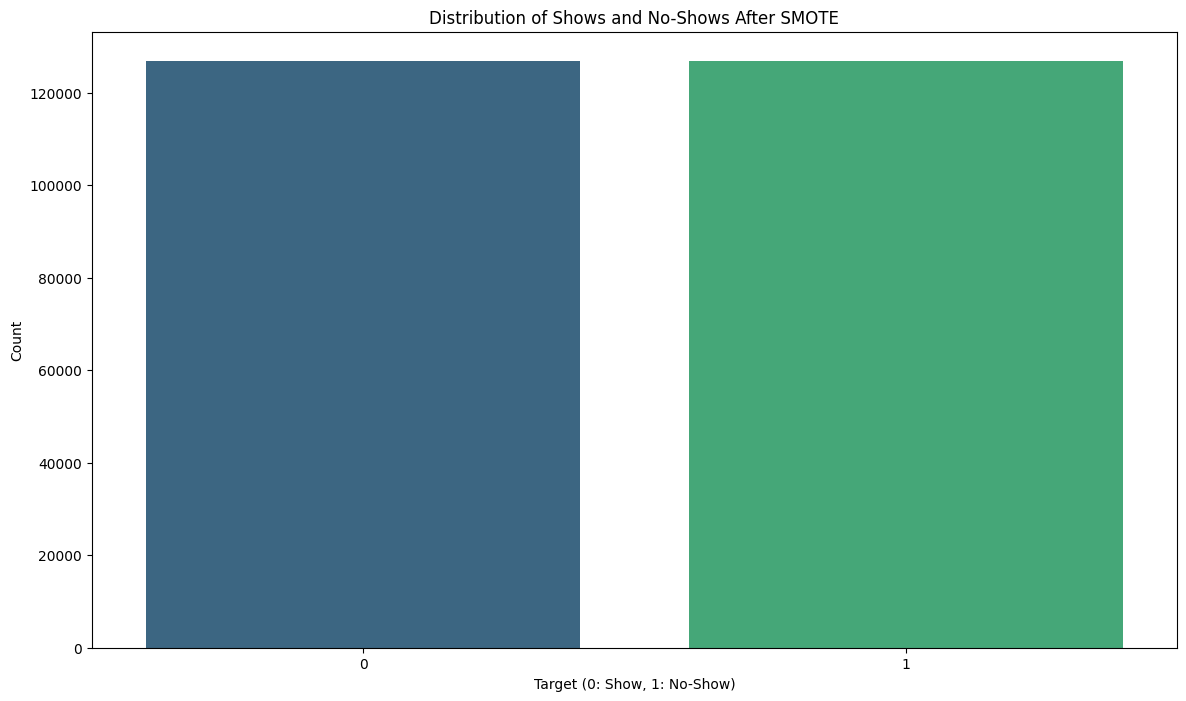

In [27]:
# Plot the distribution of shows and no-shows
sns.countplot(x=y_res, palette='viridis')
plt.title('Distribution of Shows and No-Shows After SMOTE')
plt.xlabel('Target (0: Show, 1: No-Show)')
plt.ylabel('Count')
plt.show()


In [63]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

In [64]:
# Drop rows with missing values
X = X.dropna()

In [65]:
# Ensure corresponding Y values are also dropped
Y = Y[X.index]

In [66]:
# Apply SMOTETomek
smk = SMOTETomek(random_state=42)
X_res, y_res = smk.fit_resample(X, Y)

In [67]:
# Check the shapes of the resampled data
print(X_res.shape)
print(y_res.shape)

(253480, 330)
(253480,)


In [68]:
from collections import Counter
 
# Print the original dataset class distribution
print('Original dataset shape: {}'.format(Counter(Y)))
 
# Print the resampled dataset class distribution
print('Resampled dataset shape: {}'.format(Counter(y_res)))

Original dataset shape: Counter({0: 126852, 1: 5350})
Resampled dataset shape: Counter({0: 126740, 1: 126740})


In [69]:
from imblearn.over_sampling import RandomOverSampler
 
# Initialize RandomOverSampler with a 1:1 sampling strategy
os = RandomOverSampler(sampling_strategy=1.0, random_state=42)
 
# Fit and resample the data
X_res, y_res = os.fit_resample(X, Y)
 
# Check the shapes of the resampled data
print(X_res.shape)
print(y_res.shape)

(253704, 330)
(253704,)


In [70]:
from collections import Counter
 
# Print the original dataset class distribution
print('Original dataset shape: {}'.format(Counter(Y)))
 
# Print the resampled dataset class distribution
print('Resampled dataset shape: {}'.format(Counter(y_res)))

Original dataset shape: Counter({0: 126852, 1: 5350})
Resampled dataset shape: Counter({0: 126852, 1: 126852})


In [75]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and target variables respectively
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [76]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
 
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 150),  # Number of trees in the forest
    'max_depth': randint(5, 30),       # Maximum depth of the tree
    'min_samples_split': randint(2, 10), # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 10),  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]          # Whether bootstrap samples are used when building trees
}
 
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=RANDOM_SEED)
 
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings to sample
    cv=5,        # Number of cross-validation folds
    verbose=2,   # Verbosity level
    n_jobs=-1,   # Use all available cores
    random_state=RANDOM_SEED
)


In [78]:
# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=24, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time=  33.1s
[CV] END bootstrap=True, max_depth=24, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time=  33.4s
[CV] END bootstrap=True, max_depth=24, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time=  33.7s
[CV] END bootstrap=True, max_depth=24, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time=  34.0s
[CV] END bootstrap=True, max_depth=24, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time=  34.5s
[CV] END bootstrap=True, max_depth=23, min_samples_leaf=7, min_samples_split=4, n_estimators=124; total time=  50.9s
[CV] END bootstrap=True, max_depth=23, min_samples_leaf=7, min_samples_split=4, n_estimators=124; total time=  51.3s
[CV] END bootstrap=True, max_depth=23, min_samples_leaf=7, min_samples_split=4, n_estimators=124; total time=  51.5s
[CV] E

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x161ccd6a0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x161ccda30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16b5caac0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x161cc9970>},
                   random_state=42, verbose=2)

In [79]:
# Print the best parameters and score
print("Best Parameters:\n", random_search.best_params_)
print("Best Score:\n", random_search.best_score_)

Best Parameters:
 {'bootstrap': False, 'max_depth': 29, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 58}
Best Score:
 0.9622072402150661


In [80]:
from sklearn.metrics import classification_report
 
# Initialize the classifier with the best parameters
best_rf = random_search.best_estimator_
 
# Fit the model on the training data
best_rf.fit(X_train, y_train)
 
# Predict on the test data
y_pred = best_rf.predict(X_test)
 
# Generate the classification report
report = classification_report(y_test, y_pred, target_names=LABELS)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

        Show       0.96      1.00      0.98     25319
     No Show       1.00      0.09      0.16      1122

    accuracy                           0.96     26441
   macro avg       0.98      0.54      0.57     26441
weighted avg       0.96      0.96      0.95     26441



In [1]:
data.head()

NameError: name 'data' is not defined